In [38]:
import numpy as np
from matplotlib import image as mpimg
from matplotlib import pyplot as plt, image as mpimg
from skimage.color import rgb2hsv, rgb2lab
import zipfile
import os
os.environ["OMP_NUM_THREADS"] = "6"

In [98]:
### The main function
def binary_filtering(img, K=3, luminosity_threshold=40,
        hsv_green=(60, 125),
        hsv_red1=(0, 10),
        hsv_red2=(350, 360),
        hsv_blue=(220, 250),
        max_hue_std=15
    ):
    ## Preprocessing
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32) / 255.0

    h, w, _ = img.shape
    flat = img.reshape(-1, 3)

    ## Cluster
    kmeans = KMeans(n_clusters=K, n_init="auto").fit(flat)
    labels = kmeans.labels_.reshape(h, w)

    ## Color
    hsv = rgb2hsv(img)
    H = hsv[:, :, 0] * 360

    lab = rgb2lab(img)
    L = lab[:, :, 0]

    ## Cuts
    for k in range(K):
        mask = (labels == k)
        cluster_lum = np.max(L[mask])

        if cluster_lum < luminosity_threshold:
            continue
            
        cluster_hue = np.mean(H[mask])
        cluster_hue_std = np.std(H[mask])

        # Skip clusters with inconsistent hue
        if cluster_hue_std > max_hue_std:
            continue

        # Check if the cluster hue corresponds to aurora colors
        green = hsv_green[0] <= cluster_hue <= hsv_green[1]
        red = (hsv_red1[0] <= cluster_hue <= hsv_red1[1]) or (hsv_red2[0] <= cluster_hue <= hsv_red2[1])
        blue = hsv_blue[0] <= cluster_hue <= hsv_blue[1]

        if green or red or blue:
            return True
    ## Additional check: hue at max luminosity pixel
    max_idx = np.unravel_index(np.argmax(L), L.shape)
    max_hue = H[max_idx]

    green = hsv_green[0] <= max_hue <= hsv_green[1]
    red = (hsv_red1[0] <= max_hue <= hsv_red1[1]) or (hsv_red2[0] <= max_hue <= hsv_red2[1])
    blue = hsv_blue[0] <= max_hue <= hsv_blue[1]

    if green or red or blue:
        return True
    ## If no prior condition is met:
    return False

In [102]:
test_folder = "aurora_images/Testimages"
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
N = len(image_files)

filtered = [False]*N

for i,image in enumerate(image_files):
    img_path = os.path.join(test_folder, image)
    img = mpimg.imread(img_path)
    truth = binary_filtering(img)
    filtered[i]=truth
print(np.sum(filtered),N)

835 846


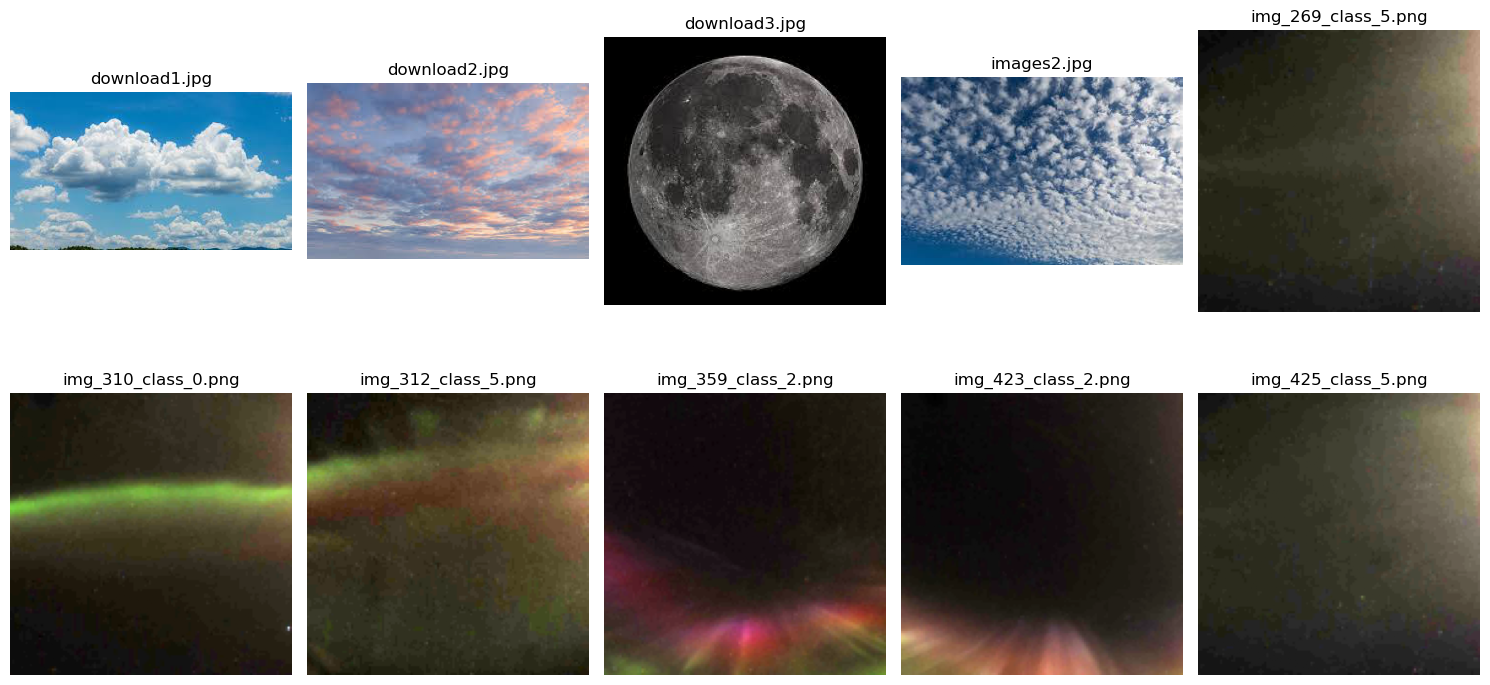

In [100]:
false_indices = [i for i, val in enumerate(filtered) if not val]
idx = false_indices[:10]
plt.figure(figsize=(15, 8))

for idx, image_idx in enumerate(idx):
    img_path = os.path.join(test_folder, image_files[image_idx])
    img = mpimg.imread(img_path)
    
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_files[image_idx])

plt.tight_layout()
plt.show()

In [7]:
#### This was used to extract the images from a zip file download

# # zip_path = r"C:\Users\ishaa\Downloads\dataverse_files.zip"

# # extract_folder = "aurora_images"
# # os.makedirs(extract_folder, exist_ok=True)

# # with zipfile.ZipFile(zip_path, 'r') as zip_ref:
# #     zip_ref.extractall(extract_folder)

# base_folder = "aurora_images"
# # Loop over all zip files in aurora_images
# for zip_name in ["Trainingimages.zip", "Testimages.zip"]:
#     zip_path = os.path.join(base_folder, zip_name)
    
#     # Create folder for extracted contents
#     extract_folder = os.path.join(base_folder, zip_name.replace(".zip",""))
#     os.makedirs(extract_folder, exist_ok=True)
    
#     # Extract the zip
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_folder)

In [25]:
import os
import warnings
import numpy as np
from matplotlib import image as mpimg
from skimage.color import rgb2hsv
from sklearn.cluster import MiniBatchKMeans

### Note this is not really needed, it was just a sanity check to see
### what color an aurora is lol
### Also note that this gets mean dominant hue, so the actual range is larger

# Suppress the MKL KMeans warning on Windows
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

def get_dominant_hue(folder_path, num_clusters=3, min_saturation=0.2, min_value=0.1, max_images=3000):
    """
    Computes robust hue ranges for green, red, and blue auroras from a folder of images.
    
    Parameters:
    - folder_path: folder containing aurora images
    - num_clusters: number of dominant hues to find per image
    - min_saturation: ignore pixels with S < this
    - min_value: ignore pixels with V < this
    - max_images: only process first N images
    
    Returns:
    - hue_ranges: dict with keys 'green', 'red', 'blue', each a (min,max) tuple
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_files = image_files[:max_images]  # limit to first max_images
    
    all_cluster_hues = []

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)

        # Normalize to 0-1 if needed
        if img.dtype != np.float32 and img.dtype != np.float64:
            img = img.astype(np.float32) / 255.0

        # Convert to HSV
        hsv = rgb2hsv(img)
        H = hsv[:, :, 0] * 360  # degrees
        S = hsv[:, :, 1]
        V = hsv[:, :, 2]

        # Mask dark / unsaturated pixels
        mask = (V > min_value) & (S > min_saturation)
        H_masked = H[mask].reshape(-1, 1)
        if H_masked.size == 0:
            continue

        # Cluster hues in 1D using MiniBatchKMeans with large batch_size to avoid MKL warning
        k = min(num_clusters, H_masked.shape[0])
        kmeans = MiniBatchKMeans(n_clusters=k, n_init="auto", batch_size=5000).fit(H_masked)
        cluster_centers = kmeans.cluster_centers_.flatten()

        # Save cluster centers for aggregation
        all_cluster_hues.extend(cluster_centers)

    all_cluster_hues = np.array(all_cluster_hues)

    # Assign clusters to approximate color ranges
    green_hues = all_cluster_hues[(all_cluster_hues >= 80) & (all_cluster_hues <= 140)]
    red_hues = all_cluster_hues[(all_cluster_hues <= 20) | (all_cluster_hues >= 340)]
    blue_hues = all_cluster_hues[(all_cluster_hues >= 200) & (all_cluster_hues <= 260)]

    def compute_range(arr):
        if len(arr) == 0:
            return None
        return (np.min(arr), np.max(arr))

    hue_ranges = {
        "green": compute_range(green_hues),
        "red": compute_range(red_hues),
        "blue": compute_range(blue_hues)
    }

    return hue_ranges


folder = "aurora_images/Trainingimages" 
hue_ranges = get_dominant_hue(folder)
print("Calibrated hue ranges (degrees):")
print(hue_ranges)

Calibrated hue ranges (degrees):
{'green': (80.00262, 124.878716), 'red': (6.108659, 353.0838), 'blue': (223.27794, 242.1717)}


In [101]:
img_path = "aurora_images/Testimages/img_310_class_0.png"
img = mpimg.imread(img_path)

# Convert to float 0-1 if needed
if img.dtype != np.float32 and img.dtype != np.float64:
    img = img.astype(np.float32) / 255.0

# Convert to LAB color space
lab = rgb2lab(img)
L = lab[:, :, 0]  # L channel = lightness/luminosity
print(np.max(L))

max_idx = np.unravel_index(np.argmax(L), L.shape)
hsv = rgb2hsv(img)
H = hsv[:, :, 0] * 360  # degrees

# Hue at the brightest pixel
max_hue = H[max_idx]
print("Hue at max luminosity pixel (degrees):", max_hue)

88.13037
Hue at max luminosity pixel (degrees): 202.10527
